The purpose of this notebook is to demonstrate the modeling process, ultimately settling on a final model and then evaluating its performance.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
import tensorflow as tf
import metric_functions as mf

Using TensorFlow backend.


In [1]:
pip install Pillow --user

     |████████████████████████████████| 2.1MB 1.5MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install keras --user

     |████████████████████████████████| 378kB 1.1MB/s eta 0:00:01
     |████████████████████████████████| 276kB 1.3MB/s eta 0:00:01
Failed to build pyyaml
    Running setup.py install for pyyaml ... done
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install sklearn --user

     |████████████████████████████████| 7.3MB 230kB/s eta 0:00:01
     |████████████████████████████████| 307kB 1.5MB/s eta 0:00:01
Failed to build sklearn
    Running setup.py install for sklearn ... done
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


# Compile and Create Data <a id='data'></a>

## Identify Working Directory

In [2]:
working_directory = 'mixed_frames_remove_60'

In [3]:
train_folder = os.path.join('mcu_data', working_directory, 'train')
train_mcu = os.path.join(train_folder, 'mcu')
train_non = os.path.join(train_folder, 'non_mcu')

test_folder = os.path.join('mcu_data', working_directory, 'test')
test_mcu = os.path.join(test_folder, 'mcu')
test_non = os.path.join(test_folder, 'non_mcu')

print('There are', len(os.listdir(train_mcu)) + len(os.listdir(train_non)), 'images in the Train set')
print('There are', len(os.listdir(test_mcu)) + len(os.listdir(test_non)), 'images in the Test set')

print('\n')

print('There are', len(os.listdir(train_mcu)), 'MCU images in the train set')
print('There are', len(os.listdir(train_non)), 'non-MCU images in the train set')
print('There are', len(os.listdir(test_mcu)), 'MCU images in the test set')
print('There are', len(os.listdir(test_non)), 'non-MCU images in the test set')

There are 5111 images in the Train set
There are 2285 images in the Test set


There are 2419 MCU images in the train set
There are 2692 non-MCU images in the train set
There are 604 MCU images in the test set
There are 1681 non-MCU images in the test set


### Create input data with image size of 128 x 128

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size = (128, 128),
    batch_size = 4090,
    color_mode = 'grayscale',
    subset = 'training')

val_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size = (128, 128),
    batch_size = 1021,
    color_mode = 'grayscale',
    subset = 'validation')

Found 4090 images belonging to 2 classes.
Found 1021 images belonging to 2 classes.


In [5]:
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder, target_size=(128, 128), color_mode = 'grayscale', batch_size = 2285)

Found 2285 images belonging to 2 classes.


In [6]:
class_labels = ['Non-MCU', 'MCU']
train_images, train_labels = next(train_generator)
val_images, val_labels = next(val_generator)
test_images, test_labels = next(test_generator)
train_y = np.reshape(train_labels[:,0], (4090,1))
val_y = np.reshape(val_labels[:,0], (1021,1))
test_y = np.reshape(test_labels[:,0], (2285,1))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))

train_images shape: (4090, 128, 128, 1)
train_labels shape: (4090, 2)
val_images shape: (1021, 128, 128, 1)
val_labels shape: (1021, 2)
test_images shape: (2285, 128, 128, 1)
test_labels shape: (2285, 2)


# Models <a id='models'></a>


In [7]:
model_baseline = models.Sequential()
model_baseline.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model_baseline.add(layers.MaxPooling2D((2, 2)))

model_baseline.add(layers.Conv2D(64, (6, 6), activation='relu'))
model_baseline.add(layers.MaxPooling2D((2, 2)))

model_baseline.add(layers.Conv2D(64, (5, 5), activation='relu'))
model_baseline.add(layers.MaxPooling2D((2, 2)))

model_baseline.add(layers.Conv2D(64, (4, 4), activation='relu'))
model_baseline.add(layers.MaxPooling2D((2, 2)))

model_baseline.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_baseline.add(layers.MaxPooling2D((2, 2)))

model_baseline.add(layers.Flatten())
model_baseline.add(layers.Dense(64, activation='relu'))
model_baseline.add(layers.Dense(1, activation='sigmoid'))

model_baseline.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [8]:
early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 5)]
history_baseline = model_baseline.fit(train_images,
                                    train_y,
                                    epochs=50,
                                    batch_size=50,
                                    validation_data=(val_images, val_y),
                                    callbacks=early_stopping)

Train on 4090 samples, validate on 1021 samples
Epoch 1/50
4090/4090 [==============================] - 8s 2ms/step - loss: 0.6981 - acc: 0.5355 - val_loss: 0.6812 - val_acc: 0.5965
Epoch 2/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.6738 - acc: 0.5641 - val_loss: 0.6292 - val_acc: 0.6650
Epoch 3/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.6576 - acc: 0.6161 - val_loss: 0.6064 - val_acc: 0.6827
Epoch 4/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.6369 - acc: 0.6452 - val_loss: 0.6205 - val_acc: 0.6738
Epoch 5/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.6146 - acc: 0.6606 - val_loss: 0.6087 - val_acc: 0.6631
Epoch 6/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.5913 - acc: 0.6870 - val_loss: 0.5858 - val_acc: 0.6592
Epoch 7/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.5465 - acc: 0.7279 - val_loss: 0.6626 - val_acc: 0.6435
Epoch 8/50
409

Accuracy 
 Train: 0.819, Test: 0.616
Loss 
 Train: 0.410, Test: 0.981 



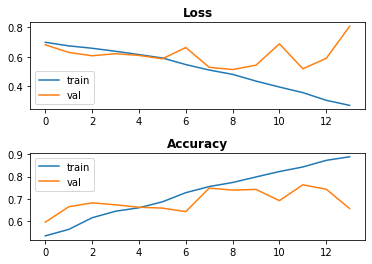



Confusion Matrix, without normalization


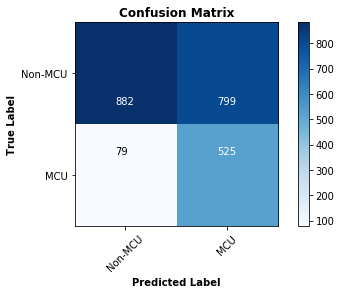



              precision    recall  f1-score   support

     Non-MCU       0.92      0.52      0.67      1681
         MCU       0.40      0.87      0.54       604

    accuracy                           0.62      2285
   macro avg       0.66      0.70      0.61      2285
weighted avg       0.78      0.62      0.64      2285



In [9]:
print(mf.evaluate_test(model_baseline, history_baseline, class_labels, train_images, test_images, train_y, test_y))

### Model 1
- x4 Hidden Layer Units
- x2 Activation Layer Units

In [10]:
model_1 = models.Sequential()
model_1.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model_1.add(layers.MaxPooling2D((2, 2)))

model_1.add(layers.Conv2D(64, (6, 6), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))

model_1.add(layers.Conv2D(128, (5, 5), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))

model_1.add(layers.Conv2D(256, (4, 4), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))

model_1.add(layers.Conv2D(512, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))

model_1.add(layers.Flatten())
model_1.add(layers.Dense(128, activation='relu'))
model_1.add(layers.Dense(1, activation='sigmoid'))

model_1.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [11]:
%%time
early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 5)]
history_1 = model_1.fit(train_images,
                         train_y,
                         epochs=50,
                         batch_size=50,
                         validation_data=(val_images, val_y),
                         callbacks=early_stopping)

Train on 4090 samples, validate on 1021 samples
Epoch 1/50
4090/4090 [==============================] - 7s 2ms/step - loss: 0.7600 - acc: 0.5242 - val_loss: 0.6886 - val_acc: 0.5132
Epoch 2/50
4090/4090 [==============================] - 7s 2ms/step - loss: 0.7069 - acc: 0.5315 - val_loss: 0.6507 - val_acc: 0.6405
Epoch 3/50
4090/4090 [==============================] - 7s 2ms/step - loss: 0.6706 - acc: 0.5856 - val_loss: 0.6261 - val_acc: 0.6915
Epoch 4/50
4090/4090 [==============================] - 7s 2ms/step - loss: 0.6474 - acc: 0.6296 - val_loss: 0.5888 - val_acc: 0.7120
Epoch 5/50
4090/4090 [==============================] - 7s 2ms/step - loss: 0.6352 - acc: 0.6511 - val_loss: 0.6551 - val_acc: 0.6396
Epoch 6/50
4090/4090 [==============================] - 7s 2ms/step - loss: 0.6274 - acc: 0.6711 - val_loss: 0.5655 - val_acc: 0.7101
Epoch 7/50
4090/4090 [==============================] - 7s 2ms/step - loss: 0.6036 - acc: 0.6929 - val_loss: 0.5653 - val_acc: 0.7091
Epoch 8/50
409

Accuracy 
 Train: 0.918, Test: 0.760
Loss 
 Train: 0.195, Test: 0.643 



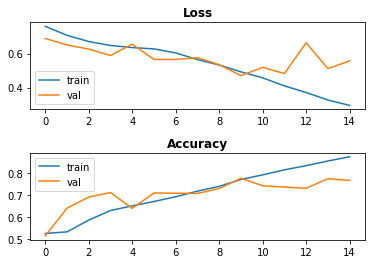



Confusion Matrix, without normalization


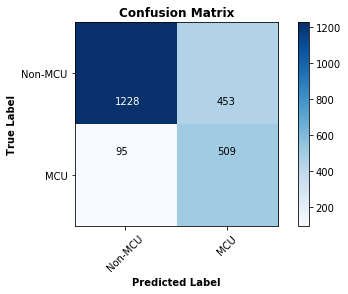



              precision    recall  f1-score   support

     Non-MCU       0.93      0.73      0.82      1681
         MCU       0.53      0.84      0.65       604

    accuracy                           0.76      2285
   macro avg       0.73      0.79      0.73      2285
weighted avg       0.82      0.76      0.77      2285



In [12]:
print(mf.evaluate_test(model_1, history_1, class_labels, train_images, test_images, train_y, test_y))

### Model 2
- x2 Input Layer Units
- x4 Hidden Layer Units
- x2 Activation Layer Units

In [13]:
model_2 = models.Sequential()
model_2.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model_2.add(layers.MaxPooling2D((2, 2)))

model_2.add(layers.Conv2D(64, (6, 6), activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))

model_2.add(layers.Conv2D(128, (5, 5), activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))

model_2.add(layers.Conv2D(256, (4, 4), activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))

model_2.add(layers.Conv2D(512, (3, 3), activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))

model_2.add(layers.Flatten())
model_2.add(layers.Dense(128, activation='relu'))
model_2.add(layers.Dense(1, activation='sigmoid'))

model_2.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [14]:
%%time
early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 5)]
history_2 = model_2.fit(train_images,
                         train_y,
                         epochs=50,
                         batch_size=50,
                         validation_data=(val_images, val_y),
                         callbacks=early_stopping)

Train on 4090 samples, validate on 1021 samples
Epoch 1/50
4090/4090 [==============================] - 11s 3ms/step - loss: 0.7036 - acc: 0.5164 - val_loss: 0.6885 - val_acc: 0.5651
Epoch 2/50
4090/4090 [==============================] - 10s 2ms/step - loss: 0.6837 - acc: 0.5738 - val_loss: 0.6444 - val_acc: 0.6474
Epoch 3/50
4090/4090 [==============================] - 10s 2ms/step - loss: 0.6606 - acc: 0.6174 - val_loss: 0.6502 - val_acc: 0.6219
Epoch 4/50
4090/4090 [==============================] - 10s 2ms/step - loss: 0.6561 - acc: 0.6210 - val_loss: 0.6141 - val_acc: 0.6572
Epoch 5/50
4090/4090 [==============================] - 10s 2ms/step - loss: 0.6475 - acc: 0.6443 - val_loss: 0.6224 - val_acc: 0.6856
Epoch 6/50
4090/4090 [==============================] - 10s 2ms/step - loss: 0.6215 - acc: 0.6687 - val_loss: 0.5851 - val_acc: 0.6934
Epoch 7/50
4090/4090 [==============================] - 10s 2ms/step - loss: 0.6008 - acc: 0.6883 - val_loss: 0.5858 - val_acc: 0.7071
Epoch 8

Accuracy 
 Train: 0.940, Test: 0.740
Loss 
 Train: 0.163, Test: 0.663 



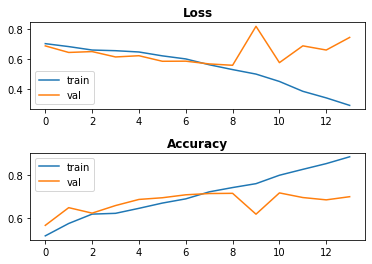



Confusion Matrix, without normalization


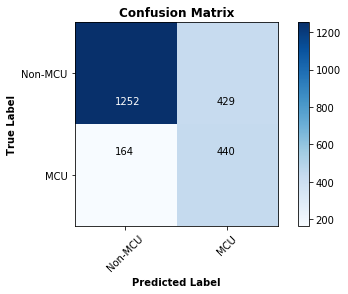



              precision    recall  f1-score   support

     Non-MCU       0.88      0.74      0.81      1681
         MCU       0.51      0.73      0.60       604

    accuracy                           0.74      2285
   macro avg       0.70      0.74      0.70      2285
weighted avg       0.78      0.74      0.75      2285



In [15]:
print(mf.evaluate_test(model_2, history_2, class_labels, train_images, test_images, train_y, test_y))

### Model 3

- x4 Hidden Layer Units
- x2 Activation Layer Units
- Double Dropout (before Flatten and after Activation)


In [16]:
model_3 = models.Sequential()
model_3.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model_3.add(layers.MaxPooling2D((2, 2)))

model_3.add(layers.Conv2D(64, (6, 6), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))

model_3.add(layers.Conv2D(128, (5, 5), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))

model_3.add(layers.Conv2D(256, (4, 4), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))

model_3.add(layers.Conv2D(512, (3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))

model_3.add(Dropout(.5))
model_3.add(layers.Flatten())
model_3.add(layers.Dense(128, activation='relu'))
model_3.add(Dropout(.5))
model_3.add(layers.Dense(1, activation='sigmoid'))

model_3.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [17]:
%%time
early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 5)]
history_3 = model_3.fit(train_images,
                         train_y,
                         epochs=50,
                         batch_size=50,
                         validation_data=(val_images, val_y),
                         callbacks=early_stopping)

Train on 4090 samples, validate on 1021 samples
Epoch 1/50
4090/4090 [==============================] - 7s 2ms/step - loss: 0.7344 - acc: 0.5139 - val_loss: 0.6918 - val_acc: 0.5132
Epoch 2/50
4090/4090 [==============================] - 7s 2ms/step - loss: 0.6885 - acc: 0.5374 - val_loss: 0.6827 - val_acc: 0.5651
Epoch 3/50
4090/4090 [==============================] - 7s 2ms/step - loss: 0.6847 - acc: 0.5924 - val_loss: 0.6220 - val_acc: 0.6464
Epoch 4/50
4090/4090 [==============================] - 7s 2ms/step - loss: 0.6441 - acc: 0.6364 - val_loss: 0.6020 - val_acc: 0.7032
Epoch 5/50
4090/4090 [==============================] - 6s 2ms/step - loss: 0.6303 - acc: 0.6628 - val_loss: 0.5805 - val_acc: 0.7111
Epoch 6/50
4090/4090 [==============================] - 7s 2ms/step - loss: 0.6128 - acc: 0.6768 - val_loss: 0.5616 - val_acc: 0.7316
Epoch 7/50
4090/4090 [==============================] - 7s 2ms/step - loss: 0.5944 - acc: 0.6895 - val_loss: 0.5428 - val_acc: 0.7522
Epoch 8/50
409

Accuracy 
 Train: 0.829, Test: 0.813
Loss 
 Train: 0.520, Test: 0.876 



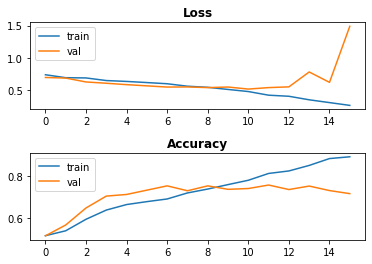



Confusion Matrix, without normalization


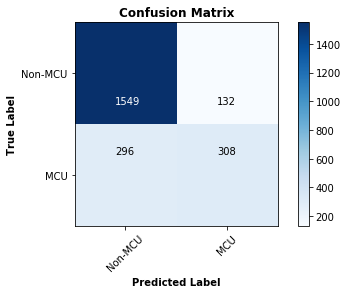



              precision    recall  f1-score   support

     Non-MCU       0.84      0.92      0.88      1681
         MCU       0.70      0.51      0.59       604

    accuracy                           0.81      2285
   macro avg       0.77      0.72      0.73      2285
weighted avg       0.80      0.81      0.80      2285



In [18]:
print(mf.evaluate_test(model_3, history_3, class_labels, train_images, test_images, train_y, test_y))

### Model 4

- x4 Hidden Layer Units
- x2 Activation Layer Units
- Dropout after activation layer


In [7]:
model_4 = models.Sequential()
model_4.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model_4.add(layers.MaxPooling2D((2, 2)))

model_4.add(layers.Conv2D(64, (6, 6), activation='relu'))
model_4.add(layers.MaxPooling2D((2, 2)))

model_4.add(layers.Conv2D(128, (5, 5), activation='relu'))
model_4.add(layers.MaxPooling2D((2, 2)))

model_4.add(layers.Conv2D(256, (4, 4), activation='relu'))
model_4.add(layers.MaxPooling2D((2, 2)))

model_4.add(layers.Conv2D(512, (3, 3), activation='relu'))
model_4.add(layers.MaxPooling2D((2, 2)))

model_4.add(layers.Flatten())
model_4.add(layers.Dense(128, activation='relu'))
model_4.add(Dropout(.5))
model_4.add(layers.Dense(1, activation='sigmoid'))

model_4.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [8]:
%%time
early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 5)]
history_4 = model_4.fit(train_images,
                         train_y,
                         epochs=50,
                         batch_size=50,
                         validation_data=(val_images, val_y),
                         callbacks=early_stopping)

Train on 4090 samples, validate on 1021 samples
Epoch 1/50
4090/4090 [==============================] - 9s 2ms/step - loss: 0.7054 - acc: 0.5191 - val_loss: 0.6910 - val_acc: 0.5818
Epoch 2/50
4090/4090 [==============================] - 7s 2ms/step - loss: 0.6938 - acc: 0.5362 - val_loss: 0.6864 - val_acc: 0.5475
Epoch 3/50
4090/4090 [==============================] - 7s 2ms/step - loss: 0.6846 - acc: 0.5785 - val_loss: 0.6154 - val_acc: 0.6680
Epoch 4/50
4090/4090 [==============================] - 7s 2ms/step - loss: 0.6621 - acc: 0.6144 - val_loss: 0.6570 - val_acc: 0.6445
Epoch 5/50
4090/4090 [==============================] - 7s 2ms/step - loss: 0.6286 - acc: 0.6643 - val_loss: 0.6104 - val_acc: 0.6934
Epoch 6/50
4090/4090 [==============================] - 7s 2ms/step - loss: 0.6242 - acc: 0.6733 - val_loss: 0.5914 - val_acc: 0.7023
Epoch 7/50
4090/4090 [==============================] - 7s 2ms/step - loss: 0.5973 - acc: 0.6910 - val_loss: 0.6086 - val_acc: 0.6797
Epoch 8/50
409

Accuracy 
 Train: 0.851, Test: 0.665
Loss 
 Train: 0.319, Test: 0.827 



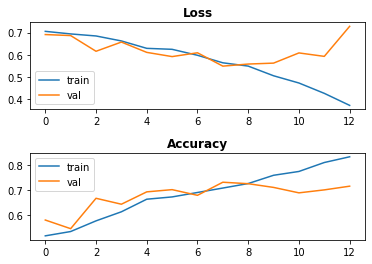



Confusion Matrix, without normalization


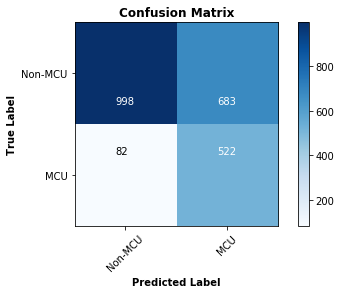



              precision    recall  f1-score   support

     Non-MCU       0.92      0.59      0.72      1681
         MCU       0.43      0.86      0.58       604

    accuracy                           0.67      2285
   macro avg       0.68      0.73      0.65      2285
weighted avg       0.79      0.67      0.68      2285



In [9]:
print(mf.evaluate_test(model_4, history_4, class_labels, train_images, test_images, train_y, test_y))

In [ ]:
model_1.save('saved_models/tuned_model_84_73')